# KAN


In [1]:
import torch
from pykan.kan.MultKAN import KAN
from scripts.preprocessing.data_loader import get_train_test_splits
from scripts.preprocessing.preprocessor import apply_minmax_scaling
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
X_train, X_test, y_train, y_test = get_train_test_splits(test_size=0.2)
X_train, y_train, train_scales = apply_minmax_scaling(X_train, y_train)
X_test, y_test, test_scales = apply_minmax_scaling(X_test, y_test)

TARGET = "ice_velocity"

y_train = y_train[TARGET]
y_test = y_test[TARGET]

# Create a dataset dictionary with both training and testing data
dataset = {
    "train_input": torch.tensor(X_train.values, dtype=torch.float32).to(device),
    "train_label": torch.tensor(y_train.values, dtype=torch.float32).to(device),
    "test_input": torch.tensor(X_test.values, dtype=torch.float32).to(device),
    "test_label": torch.tensor(y_test.values, dtype=torch.float32).to(device),
}
dataset["train_input"].shape, dataset["train_label"].shape, dataset[
    "test_input"
].shape, dataset["test_label"].shape

Train years: 2015 to 2083
Test years: 2084 to 2100


(torch.Size([155733, 19]),
 torch.Size([155733, 3]),
 torch.Size([38369, 19]),
 torch.Size([38369, 3]))

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.05e-01 | test_loss: 1.17e-01 | reg: 1.97e+03 | : 100%|█| 100/100 [03:56<00:00,  2.37


saving model version 0.1


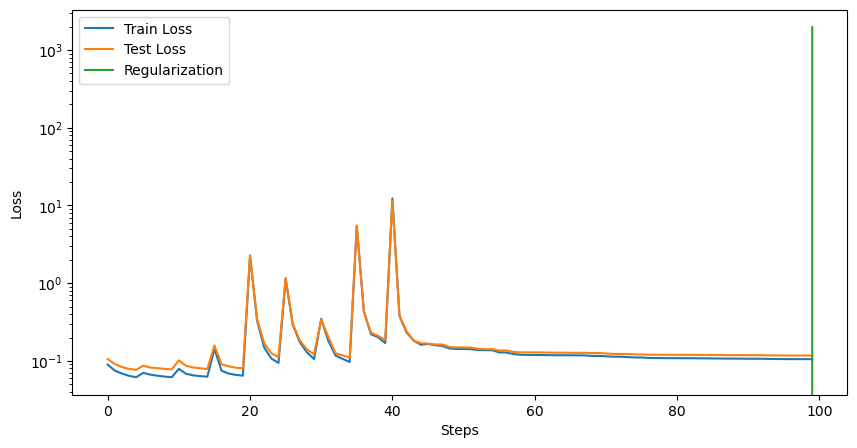

In [6]:
# Create the KAN model
model = KAN(width=[19, 16, 3], grid=5, k=3, device=device)

# Train the model
try:
    history = model.fit(dataset)
    plt.figure(figsize=(10, 5))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["test_loss"], label="Test Loss")
    plt.plot(history["reg"], label="Regularization")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.yscale("log")
    plt.show()

except Exception as e:
    print(f"An error occurred during training: {e}")

In [7]:
# Make predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_pred = model(dataset["test_input"])

# Convert predictions back to numpy for evaluation
y_pred_np = y_pred.cpu().numpy()

# Assuming your targets are continuous variables
mse = mean_squared_error(dataset["test_label"].cpu().numpy(), y_pred_np)
r2 = r2_score(dataset["test_label"].cpu().numpy(), y_pred_np)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean Squared Error: 0.013779670000076294
R2 Score: 0.48735347390174866


x: 0.1989349126815796
y: 0.09369884431362152
bedrock_elevation: 0.29519960284233093
precipitation: 0.07205862551927567
air_temperature: 0.4403507113456726
ocean_temperature: 0.08142338693141937
year: 0.08231336623430252
distance_to_pole: 0.16695767641067505
bedrock_below_sea_level: 0.09052020311355591
temperature_difference: 0.2838323712348938
log_air_temperature: 0.3437238931655884
rolling_std_precipitation: 0.08891028165817261
rolling_std_air_temperature: 0.11231027543544769
air_temperature_low_45: 136.3276824951172
bedrock_slope_x: 0.08582904189825058
bedrock_slope_y: 0.03131243586540222
bedrock_slope_magnitude: 0.07925889641046524
surface_mass_balance: 0.113026462495327
years_since_start: 0.11302445828914642
saving model version 0.2
Pruned Model - Mean Squared Error: 0.03504398092627525
Pruned Model - R2 Score: -3.4401371479034424


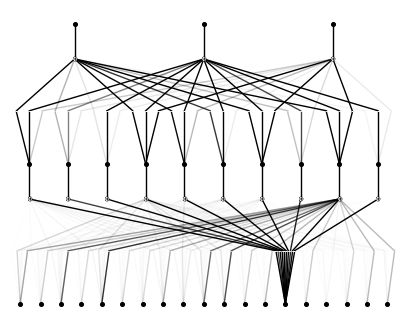

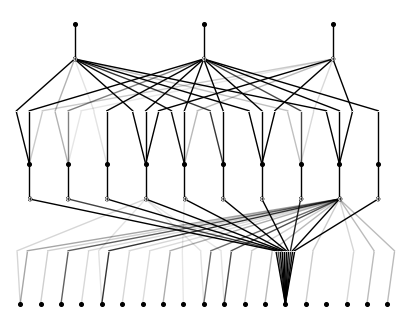

In [10]:
model.plot()
for feature, score in zip(X_train.columns, model.feature_score):
    print(f"{feature}: {score}")

# Prune the model
pruned_model = model.prune()
pruned_model.plot()

# Evaluate the pruned model
pruned_model.eval()
with torch.no_grad():
    y_pred_pruned = pruned_model(dataset["test_input"])

y_pred_pruned_np = y_pred_pruned.cpu().numpy()
mse_pruned = mean_squared_error(dataset["test_label"].cpu().numpy(), y_pred_pruned_np)
r2_pruned = r2_score(dataset["test_label"].cpu().numpy(), y_pred_pruned_np)

print(f"Pruned Model - Mean Squared Error: {mse_pruned}")
print(f"Pruned Model - R2 Score: {r2_pruned}")